In [1]:
import pandas as pd
import numpy as np
import sklearn.metrics as skm
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.cluster as sc
import datetime as dt


warnings.filterwarnings('ignore')



In [2]:
all_stations = pd.read_csv('../Thesis data/tankerkoenig-data/stations/stations.csv')
stations_count = all_stations.groupby('brand')['uuid'].count().sort_values(ascending=False)
stations_count.to_csv('Thesis Data/all_brands.csv')
print(str(stations_count.sum()))

14898


In [3]:
# Read in the data
prices_path = 'Thesis Data/Working Data/price_series.csv'
df_ser = pd.read_csv(prices_path)
df_ser = df_ser.bfill()
df_ser['time'] = pd.to_datetime(df_ser['time'])
df_ser = df_ser.set_index('time')

df_cha = pd.read_csv('Thesis Data/Working Data/price_changes.csv')
df_cha['time'] = pd.to_datetime(df_cha['time'])
df_cha = df_cha.set_index('time')

stations_path = 'Thesis Data/stations.csv'
df_station = pd.read_csv(stations_path)
df_station = df_station.set_index('uuid').drop('Unnamed: 0', axis = 1)
    
brent_path = 'Thesis Data/brent_crude_spot_time_series.csv'
df_brent = pd.read_csv(brent_path)


In [4]:
df_station.count()

name            392
brand           368
street          392
house_number    314
post_code       392
city            392
latitude        392
longitude       392
dtype: int64

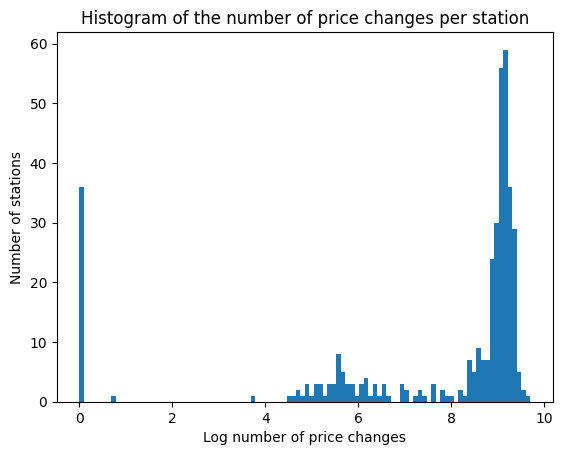

In [6]:
plot = plt.hist(np.log(df_cha.count() + 1), bins=100)
plt.title('Histogram of the number of price changes per station')
plt.xlabel('Log number of price changes')
plt.ylabel('Number of stations')
plt.show()

In [7]:
# What stations have no observations?
no_obs_uuid = df_cha.sum()[df_cha.sum() == 0].index
df_no_obs = df_cha[[col for col in df_cha.columns if col in no_obs_uuid]]
print("Stations with no changes in 2022: " + str(no_obs_uuid.shape[0]))

Stations with no changes in 2022: 40


,157c76fd-2f7e-4d81-ab55-bd69416e198d,8f9beb3d-c617-47f1-08f7-cccb612a7dce
month,,
1,42,10
2,0,5
3,0,16
4,0,7
5,0,8
6,0,6
7,0,5
8,0,0
9,0,11


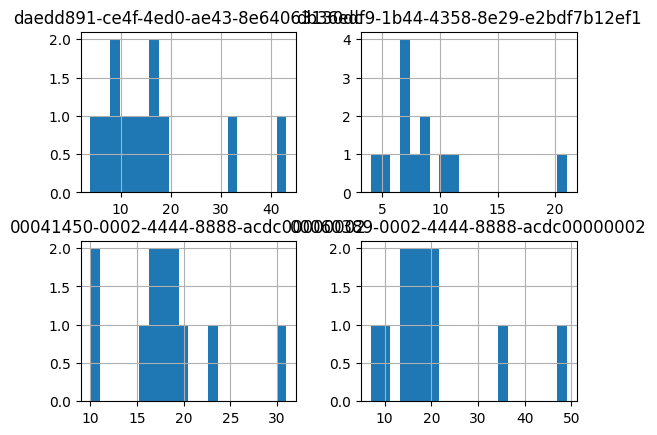

In [8]:
# What stations have low observations?
low_obs_uuid = df_cha.sum()[(df_cha.sum() < 500)&(df_cha.sum() > 0)].index
df_low_obs = df_cha[[col for col in df_cha.columns if col in low_obs_uuid]]
df_low_obs['month'] = df_low_obs.index.to_series().apply(lambda x: x.month)

# An example of 4 low observation stations
df_low_obs.iloc[:,df_low_obs.columns.size-5:].groupby('month').count().hist(bins=20)
# A count of 30 means there is one change per day on average

# Only the stations with no observations for a long series of time (month) will be removed
df_low_obs.groupby('month').count().loc[:,df_low_obs.groupby('month').count().all() == False]

In [9]:
# Remove the low observation stations - 
del df_low_obs, df_no_obs
df_cha['month'] = df_cha.index.to_series().apply(lambda x: x.month)
uuid_to_remove = df_cha.groupby('month').count().loc[:,df_cha.groupby('month').count().all() == False].columns
print("Stations to remove: " + str(uuid_to_remove.shape[0]))
df_cha = df_cha[[col for col in df_cha.columns if col not in uuid_to_remove]] 
print('Number of Stations remaining: ' + str(df_cha.columns.shape[0]))
df_cha = df_cha.drop('month', axis=1)

Stations to remove: 61
Number of Stations remaining: 332


In [10]:
# Remove the low observation stations from the price series, keep only 8am-8pm, calculate the daily average
df_ser = df_ser[[col for col in df_ser.columns if col not in uuid_to_remove]]
df_ser = df_ser[(df_ser.index.time > dt.time(8,0,0))&(df_ser.index.time < dt.time(20,0,0))]
df_day_avg = df_ser.groupby(df_ser.index.date).mean()
df_day_avg = df_day_avg.where(df_day_avg > 0).ffill().bfill()
df_day_avg = df_day_avg.drop('Unnamed: 0', axis=1)

In [11]:
print((df_day_avg.count() < 365).sum())
print(df_day_avg.loc[:,])

4
            2acc4724-ea6a-4874-baa6-e191ccb12756  \
2022-01-01                              1.756218   
2022-01-02                              1.752491   
2022-01-03                              1.736316   
2022-01-04                              1.731184   
2022-01-05                              1.732783   
...                                          ...   
2022-12-27                              1.773576   
2022-12-28                              1.774285   
2022-12-29                              1.787985   
2022-12-30                              1.772894   
2022-12-31                              1.779654   

            5a8fc6fd-6f03-4157-a7af-b0ee2b75307b  \
2022-01-01                              1.746650   
2022-01-02                              1.722074   
2022-01-03                              1.726552   
2022-01-04                              1.726622   
2022-01-05                              1.734661   
...                                          ...   
2022-12-2

In [12]:
# Cross station correlation
df_correlation = df_day_avg.drop(['time', ''], axis = 1, errors = 'ignore').corr(method='pearson')
avg_correlation = df_correlation.mean().mean()
print("Average correlation between stations: " + str(avg_correlation))
df_correlation.to_csv('Thesis Data/Working Data/series_correlation.csv')
del df_correlation 
# The average correlation between stations is about 0.94, which is strong.


Average correlation between stations: 0.949288319994352


In [13]:
# Get daily crude prices, fill in non trading days
df_brent = pd.read_csv('Thesis Data/brent_crude_spot_time_series.csv')
df_brent['Date'] = pd.to_datetime(df_brent['Date'], format='%b %d, %Y', utc=True)
df_brent['Date'] = df_brent['Date'].apply(lambda x: x.tz_convert(dt.timezone(dt.timedelta(hours = 2), 'Berlin')))
df_brent = df_brent.set_index('Date')
reindex = pd.date_range(start = df_brent.index.min(), end = df_brent.index.max(), \
    freq = 'D', \
    tz = dt.timezone(dt.timedelta(hours = 2), 'Berlin'))
#reindex = reindex.tz_convert(dt.timezone(dt.timedelta(hours = 2), 'Berlin'))
print(reindex)
df_brent = df_brent.reindex(reindex).ffill()

# Get the EUR/USD exchange rate, fill in if empty
df_forex = pd.read_csv('Thesis Data\FRB_H10.csv')
df_forex['Date'] = pd.to_datetime(df_forex['Date'], utc=True) # 
df_forex = df_forex[['Date', 'Price']]
df_forex['Date'] = df_forex['Date'].apply(lambda x: x.tz_convert(dt.timezone(dt.timedelta(hours = 2), 'Berlin'))) 
df_forex = df_forex.set_index('Date')
df_forex['Price'] = df_forex['Price'].replace('ND', np.nan).astype(float)
df_forex = df_forex.reindex(reindex).ffill()

df_brent['EUR/USD'] = df_forex['Price']

df_brent['Brent Spot Price (EUR)'] = df_brent['Europe Brent Spot Price FOB (Dollars per Barrel)']*df_brent['EUR/USD']
df_brent = df_brent[['Brent Spot Price (EUR)']]


print(df_brent.count())



DatetimeIndex(['1987-05-20 02:00:00+02:00', '1987-05-21 02:00:00+02:00',
               '1987-05-22 02:00:00+02:00', '1987-05-23 02:00:00+02:00',
               '1987-05-24 02:00:00+02:00', '1987-05-25 02:00:00+02:00',
               '1987-05-26 02:00:00+02:00', '1987-05-27 02:00:00+02:00',
               '1987-05-28 02:00:00+02:00', '1987-05-29 02:00:00+02:00',
               ...
               '2023-08-16 02:00:00+02:00', '2023-08-17 02:00:00+02:00',
               '2023-08-18 02:00:00+02:00', '2023-08-19 02:00:00+02:00',
               '2023-08-20 02:00:00+02:00', '2023-08-21 02:00:00+02:00',
               '2023-08-22 02:00:00+02:00', '2023-08-23 02:00:00+02:00',
               '2023-08-24 02:00:00+02:00', '2023-08-25 02:00:00+02:00'],
              dtype='datetime64[ns, Berlin]', length=13247, freq='D')
Brent Spot Price (EUR)    600
dtype: int64


In [14]:
# Add the crude prices to the series lagged at 0, 1, 2, 3 months
for i in range(1,4):
    df_brent['Brent Price ' + str(i) + ' Month Lag'] = df_brent['Brent Spot Price (EUR)'].shift(periods=i, freq = dt.timedelta(days=30))
df_brent_small = pd.DataFrame()
df_brent_small = df_brent[(df_brent.index > df_cha.index.min())\
    & (df_brent.index < df_cha.index.max())]

# change index to date
df_brent_small.index = df_brent_small.index.date

# df_cha = pd.concat([df_cha, df_brent_small], axis = 1, join = 'outer')
# for col in df_brent_small.columns:
#     df_cha[col] = df_cha[col].ffill().bfill()

# print('Dataframe shape: ' + str(df_cha.shape))

# assert df_cha[[col for col in df_brent_small.columns]].count().min() == df_cha[[col for col in df_brent_small.columns]].count().max() , 'There are missing values in the offset crude prices'

In [15]:
# Stack the dataframe
df_avg_stack = df_day_avg.stack(dropna = True).to_frame()
df_avg_stack.index = df_avg_stack.index.set_names(['time', 'uuid'])
df_avg_stack = df_avg_stack.rename(columns = {0: 'price_change'})
df_avg_stack = df_avg_stack.join(df_brent_small, on = 'time', how = 'outer')
df_avg_stack[df_brent_small.columns] = df_avg_stack[df_brent_small.columns].ffill().bfill() # 
df_avg_stack = df_avg_stack.dropna(how = 'any', axis = 0)
df_avg_stack.index = pd.MultiIndex.from_tuples(df_avg_stack.index, names=['time', 'uuid'])
df_avg_stack = df_avg_stack.drop('time', errors = 'ignore', axis = 1)
df_avg_stack = df_avg_stack[df_avg_stack['price_change'] != 0]
        #df_cha_stack.index = df_cha_stack.index.set_names('uuid', level = 1)
#df_cha_stack.index = df_cha_stack.index.rename(['time', 'uuid'])
# df_melt = df_cha.melt(id_vars = ['Brent Spot Price (EUR)',\
#        'Brent Price 1 Month Lag', 'Brent Price 2 Month Lag','Brent Price 3 Month Lag', 'index'],\
#         value_vars = (df_cha.columns.intersection(df_station['uuid']))).dropna(how = 'any', axis = 0, subset = ['value'])
# df_cha_melt = df_cha_melt.reindex(columns = ['variable', 'value', 'Brent Spot Price (EUR)'\
#         , 'Brent Price 1 Month Lag', 'Brent Price 2 Month Lag','Brent Price 3 Month Lag', 'index'])

print('Melted Shape: ' + str(df_avg_stack.shape))
#print(df_cha_melt.isna().sum())


Melted Shape: (119355, 5)


In [16]:
# Add price delta, change to daily frequency
df_delta_stack = df_avg_stack.groupby('uuid', as_index = False)
df_delta_stack = df_avg_stack.groupby('uuid', as_index = False).apply(lambda grp: np.log(grp) - np.log(grp.shift(1).bfill()))#.apply(lambda grp: np.log(grp))

df_delta_stack.columns = ['value', 'bt0', 'bt30', 'bt60', 'bt90']
print(df_delta_stack[df_delta_stack['value'].isna()])



Empty DataFrame
Columns: [value, bt0, bt30, bt60, bt90]
Index: []


In [17]:
print(df_delta_stack)


                                                        value       bt0  \
    time       uuid                                                       
0   2022-01-01 00041450-0002-4444-8888-acdc00000002  0.000000  0.000000   
    2022-01-02 00041450-0002-4444-8888-acdc00000002  0.000000  0.000000   
    2022-01-03 00041450-0002-4444-8888-acdc00000002  0.000000  0.000000   
    2022-01-04 00041450-0002-4444-8888-acdc00000002  0.000000  0.014995   
    2022-01-05 00041450-0002-4444-8888-acdc00000002 -0.005133  0.018573   
...                                                       ...       ...   
326 2022-12-27 feb28bec-a110-4805-9739-3d2042711489 -0.006392  0.003102   
    2022-12-28 feb28bec-a110-4805-9739-3d2042711489  0.008870 -0.012146   
    2022-12-29 feb28bec-a110-4805-9739-3d2042711489  0.003531 -0.004778   
    2022-12-30 feb28bec-a110-4805-9739-3d2042711489  0.000000  0.025523   
    2022-12-31 feb28bec-a110-4805-9739-3d2042711489  0.000000  0.000000   

                        

In [18]:
# Create linear model: log diff (gas price) ~ log diff (crude price at (t, t-1 month, t-2 month, t-3 month)) over all stations
mod = smf.ols(formula= 'value ~ bt0 + bt30 + bt60 + bt90', data = df_delta_stack)
result = mod.fit()
print(result.params)
print(result.tvalues)


Intercept    0.000046
bt0         -0.013838
bt30         0.005675
bt60         0.000624
bt90         0.045536
dtype: float64
Intercept     0.901163
bt0          -6.947161
bt30          2.769346
bt60          0.296731
bt90         21.202109
dtype: float64


In [19]:
#Add the residuals to the melted dataframe
stacked_residuals = pd.concat([df_delta_stack, pd.Series(result.resid, name = 'residuals')], axis = 1)
#col_names = melted_residuals['variable'].unique()
stacked_residuals = stacked_residuals['residuals']
print(stacked_residuals.head())
print(stacked_residuals.index)

   time        uuid                                
0  2022-01-01  00041450-0002-4444-8888-acdc00000002   -0.000046
   2022-01-02  00041450-0002-4444-8888-acdc00000002   -0.000046
   2022-01-03  00041450-0002-4444-8888-acdc00000002   -0.000046
   2022-01-04  00041450-0002-4444-8888-acdc00000002    0.000161
   2022-01-05  00041450-0002-4444-8888-acdc00000002   -0.004922
Name: residuals, dtype: float64
MultiIndex([(  0, 2022-01-01, '00041450-0002-4444-8888-acdc00000002'),
            (  0, 2022-01-02, '00041450-0002-4444-8888-acdc00000002'),
            (  0, 2022-01-03, '00041450-0002-4444-8888-acdc00000002'),
            (  0, 2022-01-04, '00041450-0002-4444-8888-acdc00000002'),
            (  0, 2022-01-05, '00041450-0002-4444-8888-acdc00000002'),
            (  0, 2022-01-06, '00041450-0002-4444-8888-acdc00000002'),
            (  0, 2022-01-07, '00041450-0002-4444-8888-acdc00000002'),
            (  0, 2022-01-08, '00041450-0002-4444-8888-acdc00000002'),
            (  0, 2022-01-09

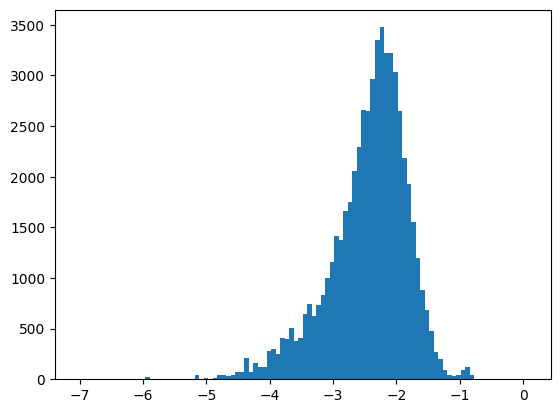

In [20]:
plt.hist(stacked_residuals.apply(np.log10), bins = 100)
plt.show()

In [21]:
# Unstack the residuals
cast_residuals = pd.DataFrame()
cast_residuals = stacked_residuals.unstack(level = 1)
print(str(cast_residuals.shape))
df_correlation = cast_residuals.corr(method='pearson', numeric_only=True)
avg_correlation = df_correlation.mean().mean()
print(avg_correlation)
# The average correlation of the residuals is .0004 - very low


(327, 365)
0.0004193308105037175


In [22]:
df_correlation

time,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,2022-01-10,...,2022-12-22,2022-12-23,2022-12-24,2022-12-25,2022-12-26,2022-12-27,2022-12-28,2022-12-29,2022-12-30,2022-12-31
time,,,,,,,,,,,,,,,,,,,,,
2022-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-02,NaN,1.000000,-0.508459,-0.240751,-0.165226,0.419880,0.304119,-0.412320,0.266287,-0.157112,...,0.060425,-0.241960,-0.508498,0.465199,-0.328786,-0.467792,0.146389,-0.187606,0.363985,0.012763
2022-01-03,NaN,-0.508459,1.000000,0.324114,0.160426,-0.324366,-0.136554,0.088263,-0.247520,0.188895,...,-0.290683,0.371071,0.352411,-0.275723,0.258611,0.221613,-0.221638,0.020100,-0.316146,0.002252
2022-01-04,NaN,-0.240751,0.324114,1.000000,-0.296555,-0.041679,-0.145670,0.115082,-0.245928,0.215246,...,-0.472198,0.408229,0.103214,-0.283430,0.274412,0.179843,0.049817,-0.103357,-0.217792,-0.051385
2022-01-05,NaN,-0.165226,0.160426,-0.296555,1.000000,-0.371395,-0.143886,0.165119,0.009811,-0.036145,...,0.138924,-0.171943,0.257902,-0.051915,-0.032063,0.248709,-0.285997,0.131609,-0.051584,-0.046871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,NaN,-0.467792,0.221613,0.179843,0.248709,-0.240116,-0.605978,0.518942,-0.249063,0.209025,...,-0.173978,0.306808,0.103183,-0.468299,0.111878,1.000000,-0.627460,0.392214,-0.053434,-0.207897
2022-12-28,NaN,0.146389,-0.221638,0.049817,-0.285997,0.066069,0.397070,-0.215860,0.116971,-0.118457,...,0.041101,-0.248982,0.026599,0.200034,-0.000390,-0.627460,1.000000,-0.384882,-0.127395,0.259043
2022-12-29,NaN,-0.187606,0.020100,-0.103357,0.131609,-0.192634,-0.215496,0.280597,-0.019252,0.012712,...,0.251390,0.058011,0.140444,-0.228527,0.071559,0.392214,-0.384882,1.000000,-0.117939,-0.132867


In [23]:
cast_residuals[cast_residuals.index == dt.date(2022, 1, 1)]

,time,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,2022-01-10,...,2022-12-22,2022-12-23,2022-12-24,2022-12-25,2022-12-26,2022-12-27,2022-12-28,2022-12-29,2022-12-30,2022-12-31
,uuid,,,,,,,,,,,,,,,,,,,,,


In [24]:
cast_residuals

,time,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,2022-01-10,...,2022-12-22,2022-12-23,2022-12-24,2022-12-25,2022-12-26,2022-12-27,2022-12-28,2022-12-29,2022-12-30,2022-12-31
,uuid,,,,,,,,,,,,,,,,,,,,,
0,00041450-0002-4444-8888-acdc00000002,-0.000046,-0.000046,-0.000046,0.000161,-0.004922,-0.000724,0.000065,-0.000046,-0.000046,0.009728,...,0.001817,0.000618,-0.000032,0.001467,-0.001865,-0.002168,-0.000576,0.000142,0.000176,-0.000197
1,00060279-0001-4444-8888-acdc00000001,-0.000046,-0.000046,-0.000046,0.000161,0.000211,0.000156,0.000065,-0.000046,-0.000046,-0.000204,...,0.003544,0.000618,-0.000032,0.001467,-0.001865,-0.002168,-0.000576,0.000142,0.000176,-0.000197
2,00060289-0001-4444-8888-acdc00000001,-0.000046,-0.000046,-0.000046,0.003185,0.006301,0.003550,0.004593,0.005523,0.002210,0.011425,...,0.003544,0.006136,-0.002110,-0.001973,-0.001865,-0.002168,-0.000576,0.000142,0.000176,-0.000197
3,00060293-0001-4444-8888-acdc00000001,-0.000046,-0.000046,-0.011763,0.005176,0.010011,-0.008845,-0.013248,-0.004655,-0.000046,0.014451,...,0.003544,0.000618,-0.000032,0.001467,-0.001865,-0.002168,-0.000576,0.000142,0.000176,-0.000197
4,00060389-0002-4444-8888-acdc00000002,-0.000046,-0.000046,-0.000046,0.000161,0.006407,0.004896,0.004246,0.003311,-0.000046,-0.000204,...,0.003544,0.000618,-0.000032,0.001467,-0.001865,-0.002168,-0.000576,0.000142,0.000176,-0.002705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,fb79c457-543a-4ff6-ba70-cd270ac2110a,-0.000046,0.004632,-0.007585,-0.012040,0.009248,-0.006041,0.003369,0.002257,0.015834,-0.007289,...,0.017075,-0.015765,0.007141,-0.002790,0.003894,-0.004536,0.003323,0.002317,-0.008321,-0.004574
323,fd3b21d3-11f7-403c-9884-3668dba7d316,-0.000046,-0.000046,0.002853,0.007515,0.002161,0.000156,0.003786,0.002279,-0.000046,-0.000204,...,-0.000600,-0.000972,-0.000032,-0.003214,-0.009260,-0.007492,-0.000576,-0.004181,-0.004231,-0.003239
324,fe50b4a5-84c9-4812-a0b7-4b29f589e1e2,-0.000046,0.006758,-0.009060,-0.005012,0.007749,-0.003688,0.005577,0.005614,0.007839,-0.010008,...,0.001914,-0.002915,0.015529,-0.000177,-0.004979,-0.004148,-0.001336,-0.002084,0.005406,-0.002864


In [25]:
# Heirarchical clustering
Z40 = sc.hierarchy.linkage(cast_residuals, method = 'complete', metric = 'correlation')

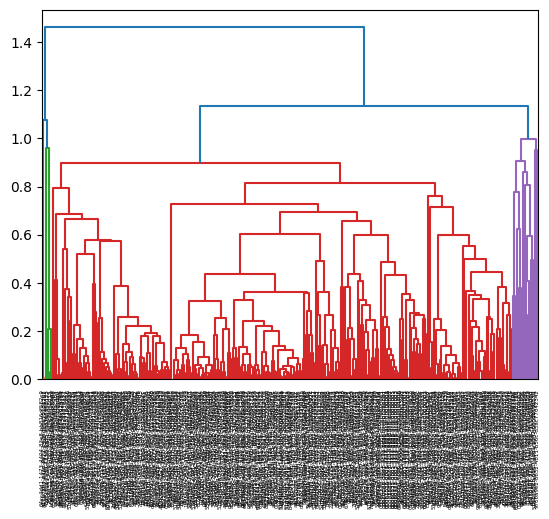

In [26]:
sc.hierarchy.dendrogram(Z40, labels = cast_residuals.index.get_level_values(1), truncate_mode = 'lastp', p = .5 , leaf_rotation = 90, leaf_font_size = 4)
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

In [27]:
# Cut tree at height .5
cuttree_40 = sc.hierarchy.cut_tree(Z40, height = .5)
cuttree_40 = pd.DataFrame(cuttree_40, index = cast_residuals.index, columns = ['cluster'])
cuttree_40 = cuttree_40.reset_index(level = 0)
cuttree_40 = cuttree_40['cluster'].to_frame()
cuttree_40['cluster'].unique()
cuttree_40

,cluster
uuid,
00041450-0002-4444-8888-acdc00000002,0
00060279-0001-4444-8888-acdc00000001,1
00060289-0001-4444-8888-acdc00000001,1
00060293-0001-4444-8888-acdc00000001,2
00060389-0002-4444-8888-acdc00000002,1
...,...
fb79c457-543a-4ff6-ba70-cd270ac2110a,0
fd3b21d3-11f7-403c-9884-3668dba7d316,1
fe50b4a5-84c9-4812-a0b7-4b29f589e1e2,0


In [28]:
# repeat for 30 km
munich_center = [48.137154, 11.576124]
# 1 degree latitude = 111.139 km
# 1 degree longitude = 111.139*cos(latitude)
radius = 30 # km
lat_factor = 111.139
long_factor = np.cos(munich_center[0]*np.pi/180)*111.139
stations30 = df_station[(lat_factor*(df_station['latitude']-munich_center[0]))**2 + (long_factor*(df_station['longitude']-munich_center[1]))**2 < radius**2]
cast_residuals_30 = cast_residuals[cast_residuals.index.get_level_values(1).isin(stations30.index)]

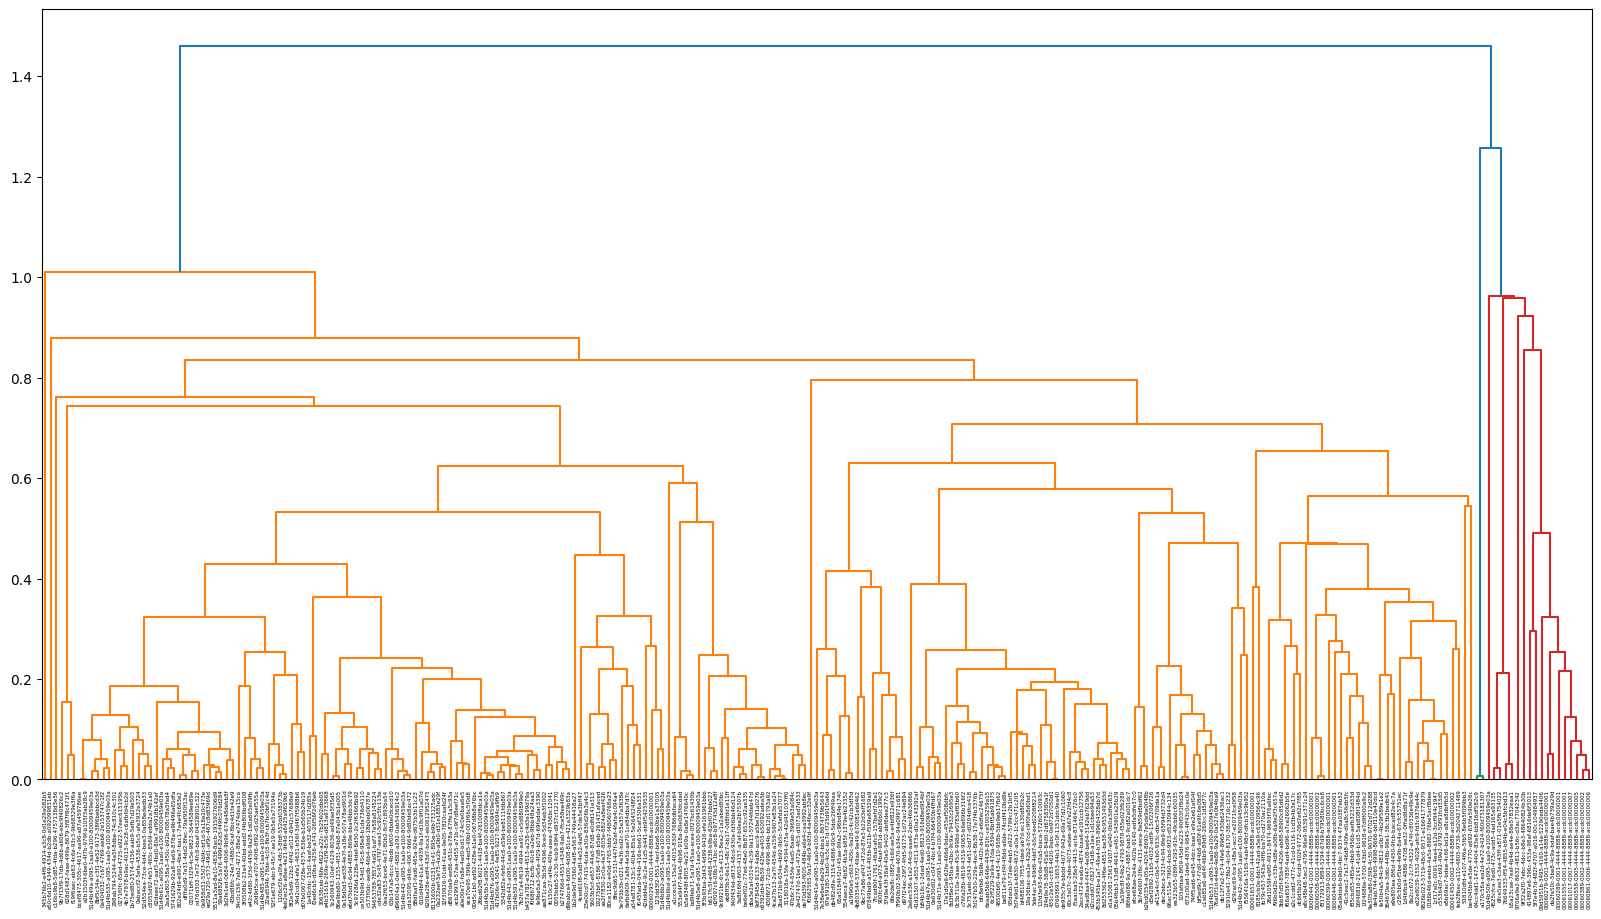

In [29]:
Z30 = sc.hierarchy.linkage(cast_residuals_30, method = 'complete', metric = 'correlation')
sc.hierarchy.dendrogram(Z30, labels = cast_residuals_30.index.get_level_values(1), truncate_mode = 'lastp', p = .5 , leaf_rotation = 90, leaf_font_size = 4)
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

In [30]:
# Cut tree at height .5
cuttree_30 = sc.hierarchy.cut_tree(Z30, height = .5)
cuttree_30 = pd.DataFrame(cuttree_30, index = cast_residuals_30.index, columns = ['cluster'])
cuttree_30 = cuttree_30.reset_index(level = 0)
cuttree_30 = cuttree_30['cluster'].to_frame()
cuttree_30['cluster'].unique()
cuttree_30

,cluster
uuid,
00041450-0002-4444-8888-acdc00000002,0
00060279-0001-4444-8888-acdc00000001,1
00060289-0001-4444-8888-acdc00000001,1
00060293-0001-4444-8888-acdc00000001,2
00060389-0002-4444-8888-acdc00000002,1
...,...
fb150c27-af4b-40fa-aaea-47436bc12041,4
fb79c457-543a-4ff6-ba70-cd270ac2110a,0
fe50b4a5-84c9-4812-a0b7-4b29f589e1e2,0


In [31]:
# repeat for 20 km
munich_center = [48.137154, 11.576124]
# 1 degree latitude = 111.139 km
# 1 degree longitude = 111.139*cos(latitude)
radius = 20 # km
lat_factor = 111.139
long_factor = np.cos(munich_center[0]*np.pi/180)*111.139
stations20 = df_station[(lat_factor*(df_station['latitude']-munich_center[0]))**2 + (long_factor*(df_station['longitude']-munich_center[1]))**2 < radius**2]
cast_residuals_20 = cast_residuals[cast_residuals.index.get_level_values(1).isin(stations20.index)]

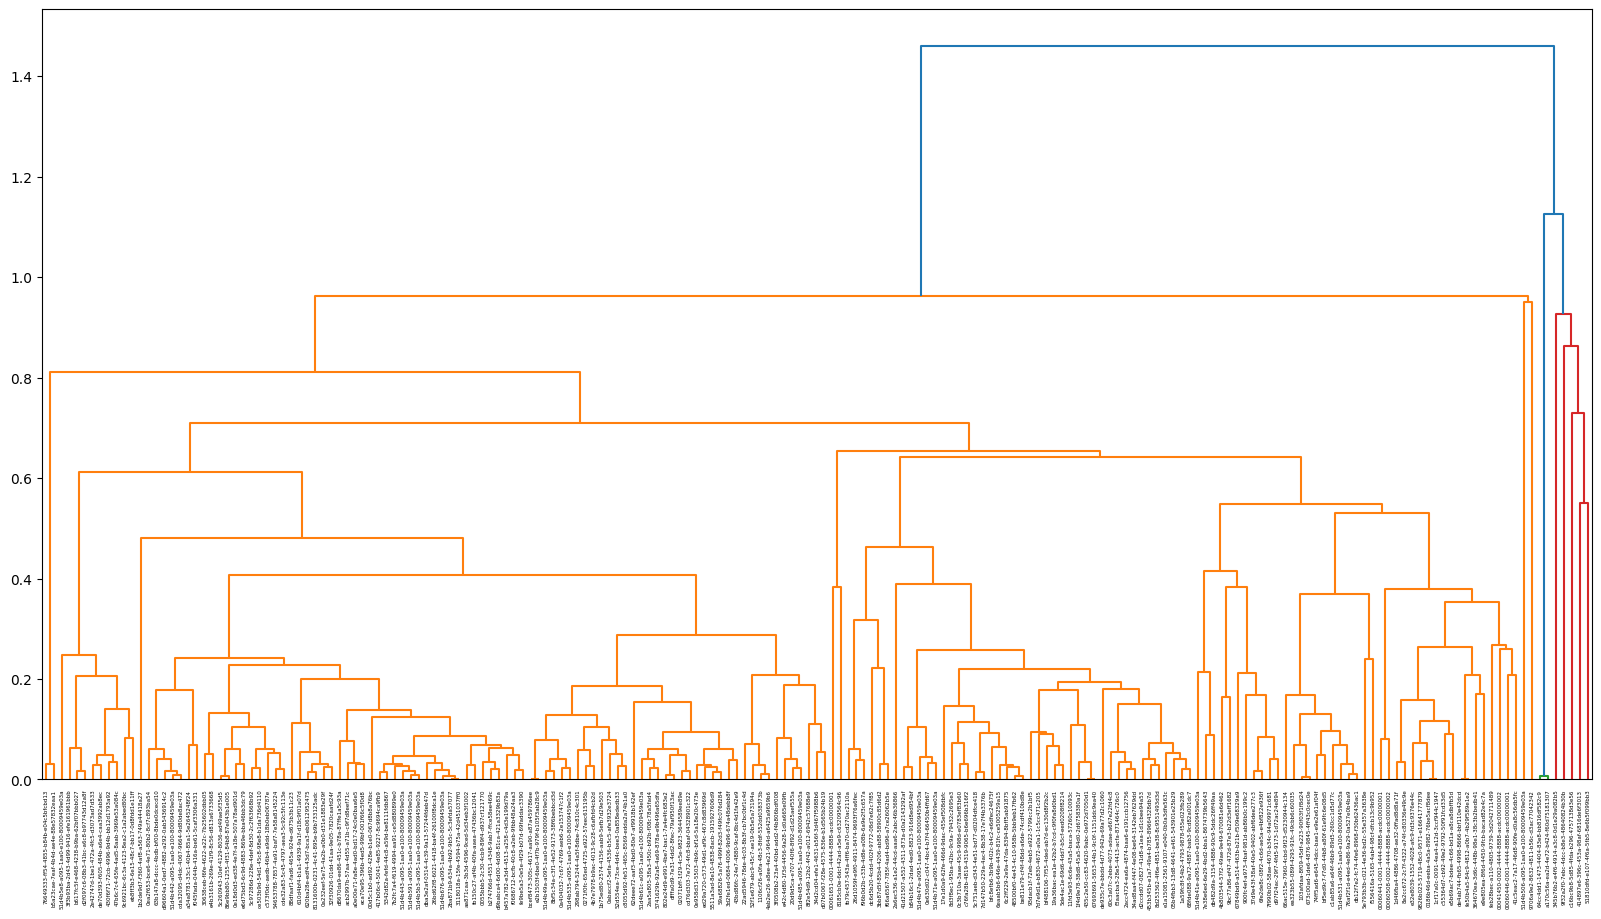

In [32]:
Z20 = sc.hierarchy.linkage(cast_residuals_20, method = 'complete', metric = 'correlation')
sc.hierarchy.dendrogram(Z20, labels = cast_residuals_20.index.get_level_values(1), truncate_mode = 'lastp', p = .5 , leaf_rotation = 90, leaf_font_size = 4)
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

In [33]:
# Cut tree at height .5
cuttree_20 = sc.hierarchy.cut_tree(Z20, height = .5)
cuttree_20 = pd.DataFrame(cuttree_20, index = cast_residuals_20.index, columns = ['cluster'])
cuttree_20 = cuttree_20.reset_index(level = 0)
cuttree_20 = cuttree_20['cluster'].to_frame()
cuttree_20['cluster'].unique()
cuttree_20

,cluster
uuid,
00041450-0002-4444-8888-acdc00000002,0
00060441-0001-4444-8888-acdc00000001,0
00060446-0001-4444-8888-acdc00000001,0
00060508-0002-4444-8888-acdc00000002,0
00061651-0001-4444-8888-acdc00000001,1
...,...
fb150c27-af4b-40fa-aaea-47436bc12041,2
fb79c457-543a-4ff6-ba70-cd270ac2110a,3
fe50b4a5-84c9-4812-a0b7-4b29f589e1e2,0


In [34]:
# repeat for 25km
radius = 25 # km
stations25 = df_station[(lat_factor*(df_station['latitude']-munich_center[0]))**2 + (long_factor*(df_station['longitude']-munich_center[1]))**2 < radius**2]
cast_residuals_25 = cast_residuals[cast_residuals.index.get_level_values(1).isin(stations25.index)]
Z25 = sc.hierarchy.linkage(cast_residuals_25, method = 'complete', metric = 'correlation')
cuttree_25 = sc.hierarchy.cut_tree(Z25, height = .5)
cuttree_25 = pd.DataFrame(cuttree_25, index = cast_residuals_25.index, columns = ['cluster'])
cuttree_25 = cuttree_25.reset_index(level = 0)
cuttree_25 = cuttree_25['cluster'].to_frame()

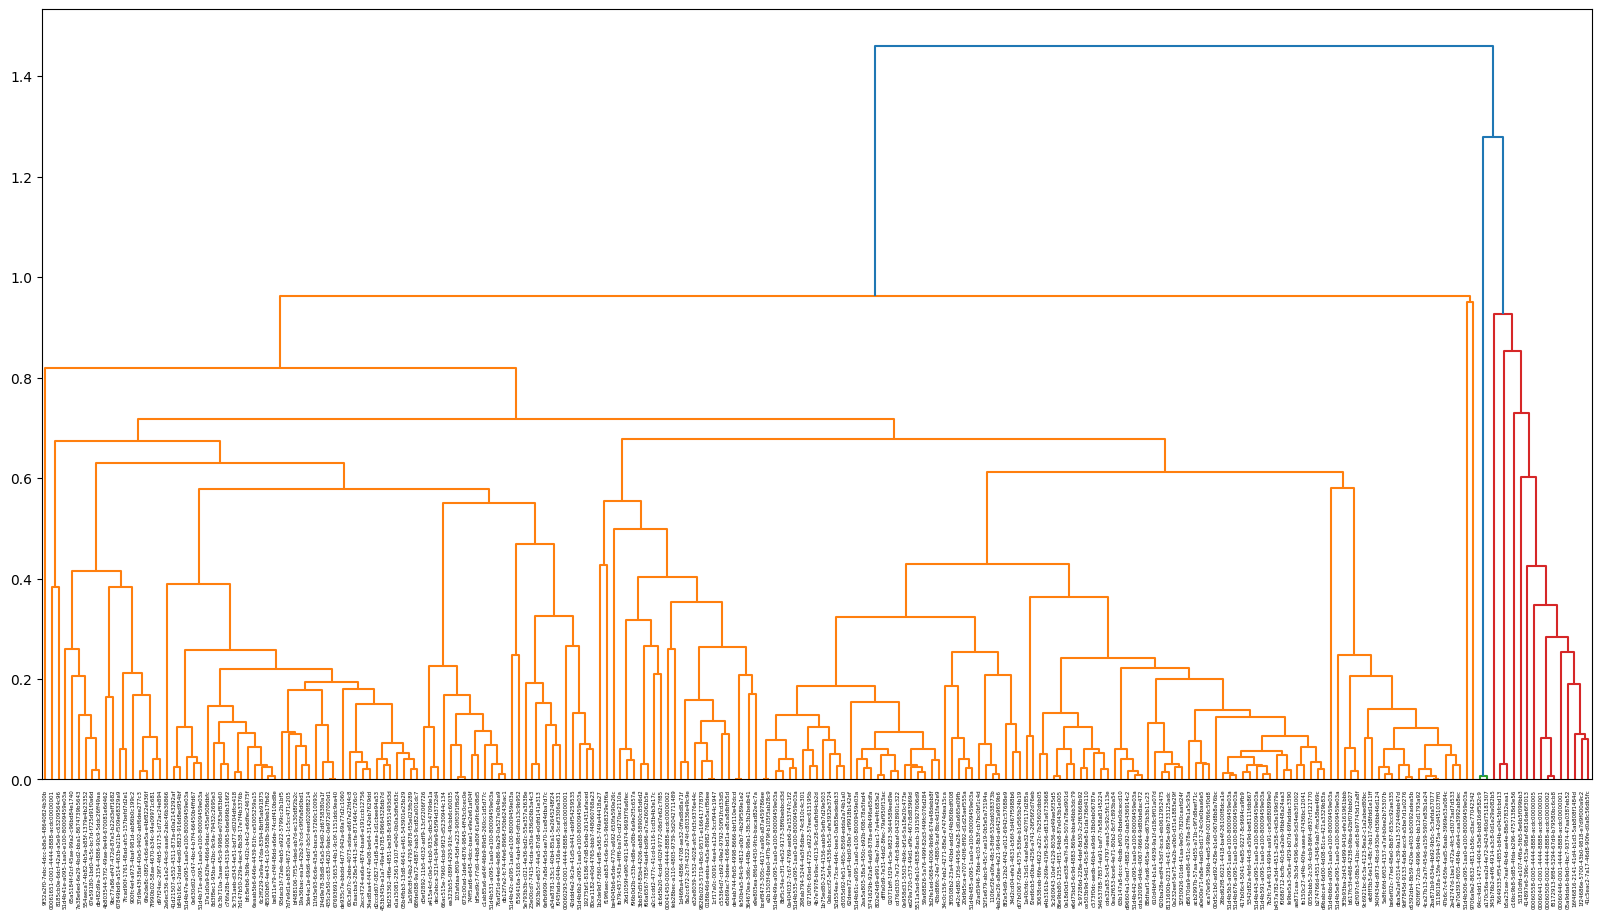

In [35]:
sc.hierarchy.dendrogram(Z25, labels = cast_residuals_25.index.get_level_values(1), truncate_mode = 'lastp', p = .5 , leaf_rotation = 90, leaf_font_size = 4)
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

In [36]:
#  35km
radius = 35 # km
stations35 = df_station[(lat_factor*(df_station['latitude']-munich_center[0]))**2 + (long_factor*(df_station['longitude']-munich_center[1]))**2 < radius**2]
cast_residuals_35 = cast_residuals[cast_residuals.index.get_level_values(1).isin(stations35.index)]
Z35 = sc.hierarchy.linkage(cast_residuals_35, method = 'complete', metric = 'correlation')
cuttree_35 = sc.hierarchy.cut_tree(Z35, height = .5)
cuttree_35 = pd.DataFrame(cuttree_35, index = cast_residuals_35.index, columns = ['cluster'])
cuttree_35 = cuttree_35.reset_index(level = 0)
cuttree_35 = cuttree_35['cluster'].to_frame()

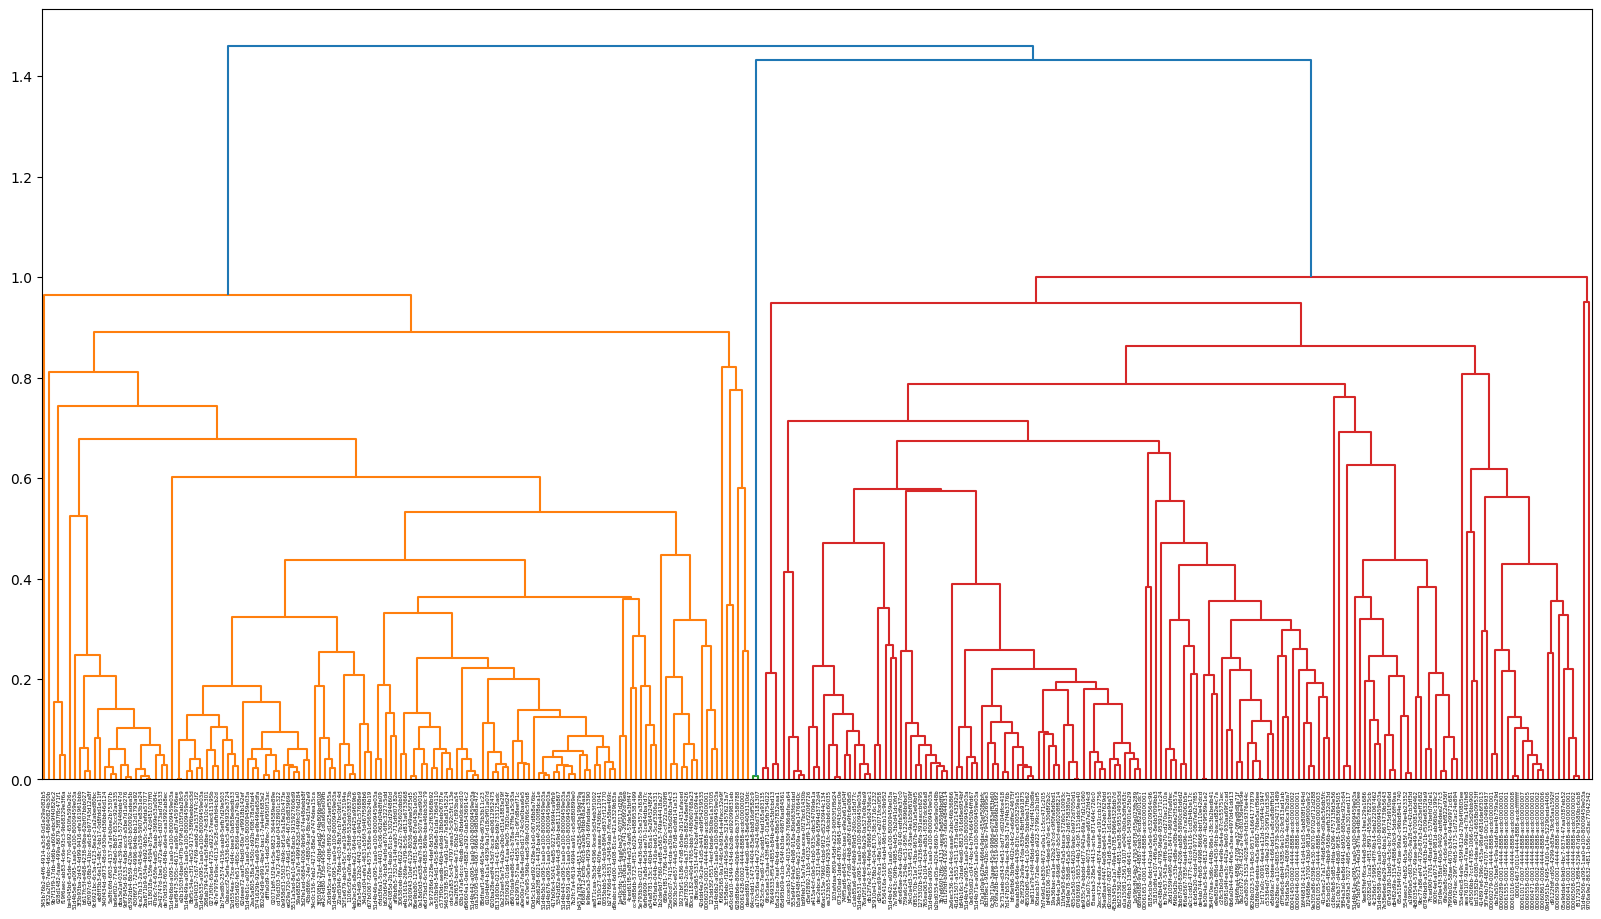

In [37]:
sc.hierarchy.dendrogram(Z35, labels = cast_residuals_35.index.get_level_values(1), truncate_mode = 'lastp', p = .5 , leaf_rotation = 90, leaf_font_size = 4)
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

In [38]:
# Create adjusted rand index matrix
comparison = pd.concat([cuttree_20, cuttree_25, cuttree_30, cuttree_35, cuttree_40], axis = 1).dropna(how = 'any')
comparison.columns = ['cluster_20','cluster_25', 'cluster_30', 'cluster_35', 'cluster_40']
comparison = comparison.apply(lambda x: x.astype(int))
radii = [20, 25, 30, 35, 40]
rand_table = pd.DataFrame(columns=radii, index=radii)
for i in radii:
    for j in radii:
        rand_table.loc[i,j] = skm.adjusted_rand_score(comparison['cluster_' + str(i)], comparison['cluster_' + str(j)])

#rand_table.applymap(lambda x: skm.adjusted_rand_score(comparison['cluster_' + str(x.name)], comparison['cluster_' + str(x.name)]))


In [39]:
rand_table.to_csv('Thesis Data/Working Data/rand_table.csv')
rand_table
# This is based on a 20 km subsample

,20,25,30,35,40
20,1.0,0.868998,0.87652,0.886464,0.883047
25,0.868998,1.0,0.985128,0.955493,0.963265
30,0.87652,0.985128,1.0,0.957815,0.950949
35,0.886464,0.955493,0.957815,1.0,0.992232
40,0.883047,0.963265,0.950949,0.992232,1.0


In [40]:
# Save stations to qgis input
all_clusters = pd.concat([cuttree_20, cuttree_25, cuttree_30, cuttree_35, cuttree_40], axis = 1)
all_clusters.columns = ['cluster_20','cluster_25', 'cluster_30', 'cluster_35', 'cluster_40']
df_grouped_stations = df_station.join(all_clusters, how = 'inner')
df_grouped_stations.to_csv('QGIS_Data/QGIS_Input/stations_40km.csv')

In [41]:
#Number of grouped stations in each subsample
df_grouped_stations.count()

name            327
brand           307
street          327
house_number    259
post_code       327
city            327
latitude        327
longitude       327
cluster_20      195
cluster_25      229
cluster_30      263
cluster_35      304
cluster_40      327
dtype: int64

In [42]:
df_grouped_stations.loc[:,['cluster_40','latitude']].groupby('cluster_40').count().sort_values(by = 'latitude', ascending = False).sum()

latitude    327
dtype: int64

In [43]:
df_grouped_stations

,name,brand,street,house_number,post_code,city,latitude,longitude,cluster_20,cluster_25,cluster_30,cluster_35,cluster_40
uuid,,,,,,,,,,,,,
2acc4724-ea6a-4874-baa6-e191ccb12756,"MUENCHEN, INNSBRUCKER RING",Shell,INNSBRUCKER RING 142,NaN,81669,MUENCHEN,48.114907,11.617154,3.0,5.0,5.0,6.0,6
5a8fc6fd-6f03-4157-a7af-b0ee2b75307b,Esso Tankstelle,ESSO,MUENCHNER STR. 14,,82319,STARNBERG,48.002091,11.348624,NaN,8.0,7.0,9.0,13
6c2ff229-2e9a-47da-8394-8bff5ab91875,Esso Tankstelle,ESSO,EFFNERSTR. 130,,81925,MUENCHEN,48.162809,11.624476,3.0,5.0,5.0,6.0,6
802e24d9-e991-4be7-bac1-7a4e4fc683e2,Aral Tankstelle,ARAL,Ingolstädter Str.,164-166,80939,München,48.201780,11.586149,2.0,4.0,4.0,5.0,5
8d21423c-093d-43d1-99e4-da01ba69a9f8,Freie Tankstellen Singer,AVIA,Hauptstr.,19,85643,Tulling,48.083397,12.059923,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8d3f8ec1-95ba-42bc-9c9a-79432c2695e3,Aral Tankstelle,ARAL,Richard Strauss-Straße,70,81679,München,48.145718,11.616339,3.0,5.0,5.0,6.0,6
900fc4ef-a973-4baf-981d-ab86b0c199c2,UNTERSCHLEIßHEIM - BEZIRKSSTRAßE,Agip,Bezirksstraße,29,85716,Unterschleißheim,48.281760,11.575789,7.0,10.0,9.0,12.0,16
90295382-9fae-42c2-b84d-1bfac2545fb5,MAITENBETH - THAL 11,Agip,Thal,11,83558,Maitenbeth-Thal,48.152753,12.089515,NaN,NaN,NaN,NaN,0


In [44]:
df_station.loc[df_grouped_stations.index.to_list()].groupby('brand')['name'].count().sort_values(ascending = False)

brand
ARAL                               57
Shell                              42
Agip                               32
ESSO                               28
OMV                                25
JET                                20
ALLGUTH                            18
TOTAL                              13
AVIA                                9
Bavaria Petrol                      8
Seitz Tankstellen                   7
Freie Tankstelle                    3
Supermarkt-Tankstelle               2
HEM                                 2
Gruber Freie Tankstelle             2
Avanti                              2
freie Tankstelle                    2
ELAN                                2
BayWa                               2
OIL!                                2
TANKHOF SAUERLACH                   1
V-Markt München Balanstrasse        1
ST 2 Tankstelle                     1
SIT                                 1
S-TANK Langenpettenbach             1
Reitmayr TS                         1
Raiffe

In [45]:
df_station.loc[df_grouped_stations.index.to_list()].groupby('brand')['name'].count().sum()

307

In [46]:
df_grouped_stations.groupby('cluster_40')['name'].count().sort_values(ascending = False)


cluster_40
5     94
6     38
0     32
1     31
16    24
13    19
2     17
10    13
9     10
21     5
12     5
8      4
17     4
11     3
7      3
28     3
3      3
23     3
25     2
4      2
22     2
29     1
27     1
26     1
15     1
24     1
20     1
19     1
18     1
14     1
30     1
Name: name, dtype: int64

In [47]:
df_grouped_stations.groupby('cluster_40')['name'].count().sort_values(ascending = True)

cluster_40
15     1
27     1
26     1
24     1
20     1
19     1
18     1
29     1
14     1
30     1
4      2
25     2
22     2
11     3
28     3
7      3
3      3
23     3
8      4
17     4
12     5
21     5
9     10
10    13
2     17
13    19
16    24
1     31
0     32
6     38
5     94
Name: name, dtype: int64

In [48]:
df_grouped_stations.groupby('cluster_20')['name'].count().sort_values(ascending = False)

cluster_20
2.0     87
3.0     44
0.0     18
4.0     12
7.0     11
5.0     10
1.0      2
11.0     2
12.0     2
6.0      1
8.0      1
9.0      1
10.0     1
13.0     1
14.0     1
15.0     1
Name: name, dtype: int64

In [49]:
#del df_cha, df_ser